In [1]:
import os, sys
from astropy.io import fits
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

%matplotlib inline

The original SLACS data are of dimension 281x281; however, the training sets are of 300x300. We need to pad the borders of the original data with noises so that the testing set looks more similar to the training set. Since the original background noises are Gaussian, we take the mu and sigma calculated to generate random noises for padding. 
(See below for details.)

(281, 15)
(15, 281)


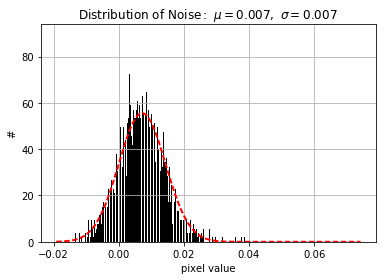

In [2]:
from scipy.stats import norm
import matplotlib.mlab as mlab

image_file = fits.open('/Users/Ralph/Desktop/summer_astro_research/HST/02/YES/SLACSJ0029-0055_53990_814_4_biz02.fits')
image_data = image_file[0].data

#border 15 pixels
a = image_data[0:281,0:15]
print(a.shape)
b = image_data[0:15,0:281]
print(b.shape)
b_t = b.transpose()
c = image_data[0:281,266:281]
d = image_data[266:281,0:281]
d_t = d.transpose()

data_sliced = np.concatenate((a,b_t,c,d_t))

# best fit of data
(mu, sigma) = norm.fit(data_sliced)

# the histogram of the data
n, bins, patches = plt.hist(data_sliced, 200, normed=1, facecolor='black')

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('pixel value')
plt.ylabel('#')
plt.title(r'$\mathrm{Distribution\ of\ Noise:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

We then generate padded images and put them in a separate folder.

In [3]:
from functions import pad

#change directory to where the original data is
os.chdir('/Users/Ralph/Desktop/test/YES')

#create a folder in another directory
if not os.path.exists("../processed/YES/padded"):
    os.makedirs("../processed/YES/padded")

#open each file in the directory
dirs = os.listdir("./")

for f in dirs:
    if not ".fits" in f:
        continue
    print "processing:",  f
    image_file = fits.open(f, ignore_missing_end=True)
    image_data = image_file[0].data
    
    #process each file in the directory
    padded = pad(image_data) 
    os.chdir("../processed/YES/padded")
    fits.writeto(f, padded, output_verify='exception', overwrite=True, checksum=False)
    os.chdir("../../../YES")
    image_file.close() 

processing: SLACSJ0029-0055_53990_814_4_biz02.fits
processing: SLACSJ0037-0942_53266_435_1_biz02.fits
processing: SLACSJ0037-0942_53266_814_1_biz02.fits


Image of the original fits file vs. padded:

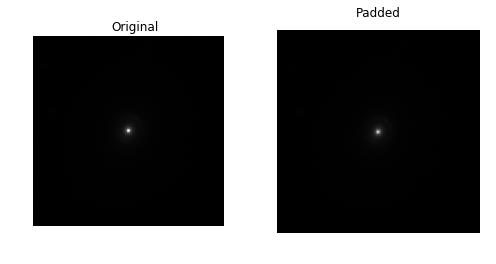

In [4]:
image_data_1 = fits.open('../../summer_astro_research/HST/02/YES/SLACSJ0029-0055_53990_814_4_biz02.fits')[0].data
image_data_2 = fits.open('../processed/YES/padded/SLACSJ0029-0055_53990_814_4_biz02.fits')[0].data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)

ax1.axis('off')
ax1.imshow(image_data_1, cmap=plt.cm.gray)
ax1.set_title('Original')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(image_data_2, cmap=plt.cm.gray)
ax2.set_title('Padded')
ax1.set_adjustable('box-forced')

plt.show()

Then we assign each of the masked pixels in SLACS data a pixel value according the value of its neighboring pixels. We use the image_mask_avg_impute() and MaskAverageImpute() functions in pipeline_image_processors.py to acheive this.

We also choose the range of pixel vlues for display in order to get a better visualization of the strong lensing features. This is done by calling the sigma_clip() function in functions.py

In [5]:
sys.path.insert(0, os.path.abspath("/Users/Ralph/Desktop/test/")) #insert path of pipeline_image_processors.py
from pipeline_image_processors import image_mask_avg_impute,MaskAverageImpute
from functions import sigma_clip

os.chdir('/Users/Ralph/Desktop/test/processed/YES/padded')
dirs = os.listdir("./")
images = os.listdir("./")
if not os.path.exists("../mask+clip"):
    os.makedirs("../mask+clip")

images = [fits.open("./" + file, ignore_missing_end=True)[0].data for file in filter(lambda x: '.fits' in x, images)]

MAI = MaskAverageImpute()
MAIed = MAI.fit_transform(images)

x = 0
for name in dirs:    
    clipped = sigma_clip(MAIed[x], 13)
    os.chdir("../mask+clip")
    fits.writeto(name, clipped, output_verify='exception', overwrite=True, checksum=False)
    x += 1